# Práctica 4: Segmentación de imágenes médicas

En esta práctica implementaremos un modelo UNet para la segmentación del ventrículo izquierdo en imágenes de resonancia magnética cardiaca.

* Para más detalles sobre la importancia de este problema de segmentación en imágenes de resonancia magnética cardíaca ver: https://www.frontiersin.org/articles/10.3389/fcvm.2020.00025/full

* Para más detalles sobre el modelo UNet, ver el paper original: https://arxiv.org/abs/1505.04597


# Configuración del entorno y descarga de datos

Primero procedemos a ejecutar el comando que nos va a descargar en el server las imágenes a analizar.

In [1]:
# Borrar resultados anteriores si los hubiera
!rm -rf CMR
# !rm -rf dlmi-uba

# Bajar las imágenes para analizar
# DESCOMENTAR LO SIGUIENTE SI SE CORRE EN COLAB
# ! git clone https://gitlab.com/eferrante/dlmi-uba.git

# Instalar las dependencias necesarias
!pip install medpy SimpleITK

# Info sobre cómo subir un dataset a google colab: https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9

# Visualizando algunas imágenes de ejemplo y seteando paths

Aquí seteamos algunos paths necesarios para indicar dónde se encuentran las imágenes de train, validation y test.

También visualizaremos algunas imágenes de ejemplo.

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)

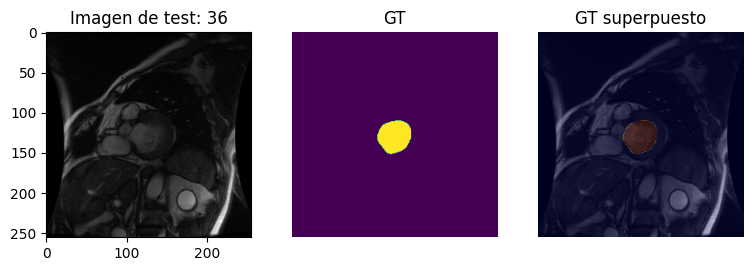

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import torch

torch.manual_seed(10)  # set seed for reproducibility
np.random.seed(10)

# Paths a los datos descargados

TRAIN_DATA_DIR = "dlmi-uba/practica3/data/Train/"
VAL_DATA_DIR = "dlmi-uba/practica3/data/Val/"
TEST_DATA_DIR = "dlmi-uba/practica3/data/Test/"

TEST_LABELS_DIR = "dlmi-uba/practica3/data/Test/Labels/"
TEST_IMAGES_DIR = "dlmi-uba/practica3/data/Test/Images/"


def visualizarImagenTest(imgNbr):
    # Leer el ground truth
    gt = io.imread(os.path.join(TEST_LABELS_DIR, str(imgNbr) + ".png"), as_gray=True)
    gt = gt[:, :].astype(np.bool).astype(np.float)

    # Leer la imagen original
    img = io.imread(os.path.join(TEST_IMAGES_DIR, str(imgNbr) + ".png"), as_gray=True)

    # Visualizar la imagen y el ground truth
    plt.figure(figsize=(9, 3), dpi=100)

    plt.subplot(1, 3, 1)
    plt.grid(False)
    plt.title("Imagen de test: " + str(imgNbr))

    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.title("GT")

    plt.imshow(gt, cmap="viridis")

    plt.subplot(1, 3, 3)
    plt.axis("off")

    plt.title("GT superpuesto")
    plt.imshow(img, cmap="gray")
    plt.imshow(gt, cmap="jet", alpha=0.25)


visualizarImagenTest(36)

Observamos intensidades e histograma de la imagen

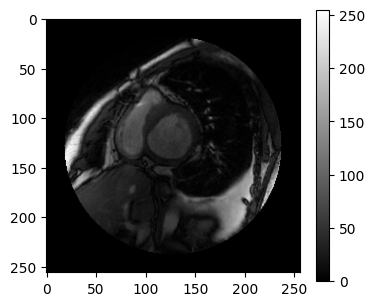

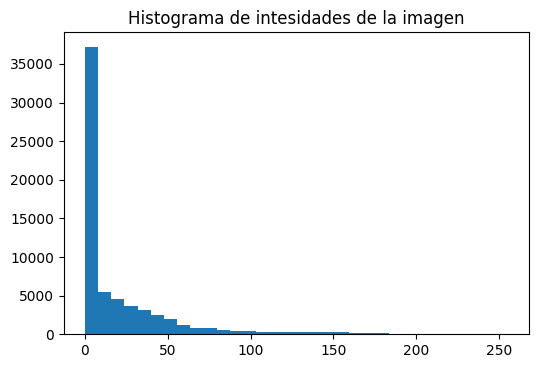

In [4]:
# Segmentación básica con SimpleITK

import SimpleITK as sitk

# Abrir la imagen y el ground truth utilizando los métodos de SimpleITK (sitk.ReadImage)
imgNbr = 20
imgPath = os.path.join(TEST_IMAGES_DIR, str(imgNbr) + ".png")
gtPath = os.path.join(TEST_LABELS_DIR, str(imgNbr) + ".png")

# Notar que nos quedamos con el canal 0 de las imagenes pq, al estar almacenadas en PNG, simpleITK las interpreta como RGB.
img = sitk.VectorIndexSelectionCast(sitk.ReadImage(imgPath), 0)
gt = sitk.VectorIndexSelectionCast(sitk.ReadImage(gtPath), 0)

# Visualizamos la imagen y el gt
plt.figure(figsize=(9, 6), dpi=100)

ax = plt.subplot(1, 2, 1)
plt.grid(False)
plt.imshow(sitk.GetArrayFromImage(img), cmap="gray")
plt.colorbar(shrink=0.6)


plt.figure(figsize=(6, 4), dpi=100)
plt.title("Histograma de intesidades de la imagen")
_ = plt.hist(sitk.GetArrayFromImage(img).flatten(), bins=32)

## Segmentación semiautomática por crecimiento de regiones

Como primer método, vamos a utilizar crecimiento de regiones con thresholds fijos. El método a utilizar será *sitk.ConnectedThreshold*.

Dicho método require una lista de semillas *seedList* en la forma [(x1,y1), (x2,y2) ... (xn,yn)], y dos parámetros indicando el límite inferior (lower) y superior *upper* permitido para el crecimiento de la región a partir de las semillas.

Para encontrar los límites, se puede utilizar thresholding sobre la imagen completa. Por ejemplo:

`seg = (img > 10) & (img < 200)`

Devolverá una segmentación que incluye todas las intensidades mayores a 10 y menores a 200.


Text(0.5, 1.0, 'Imagen umbralizada')

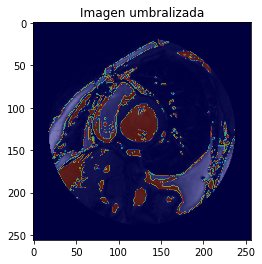

In [5]:
# UMBRALIZADO: Primero implementaremos el método de umbralizado. Para ello establecemos los límites
lower = 40
upper = 70

# La siguiente línea es útil para explorar el rango de valores en que se permitirá crecer a la región
seg_umb = (img > lower) & (img < upper)

# Visualizamos la imagen y su umbralización
plt.figure()
plt.grid(False)
plt.imshow(sitk.GetArrayFromImage(img), cmap="gray")
plt.imshow(sitk.GetArrayFromImage(seg_umb), cmap="jet", alpha=0.5)
plt.title("Imagen umbralizada")

Text(0.5, 1.0, 'Crecimiento de Regiones')

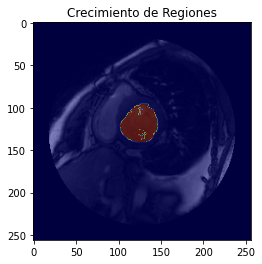

In [6]:
# REGION GROWING: Procedemos a añadir una lista de puntos semilla para los cuales se crecerá la región sobre la semillas
seedlist = [(125, 125)]

# Aqui llamaremos al método de crecimiento de regiones, indicando la posición de las semillas y los límites para el crecimiento.
seg = sitk.ConnectedThreshold(img, seedList=seedlist, lower=lower, upper=upper)

# Visualizamos la imagen y el gt
plt.figure()
plt.grid(False)
plt.imshow(sitk.GetArrayFromImage(img), cmap="gray")
plt.imshow(sitk.GetArrayFromImage(seg), cmap="jet", alpha=0.5)
plt.title("Crecimiento de Regiones")

Refinamos la segmentación usando el método `sitk.BinaryFillhole` para rellenar los huecos que puedan haber quedado.


Text(0.5, 1.0, 'Segmentación refinada')

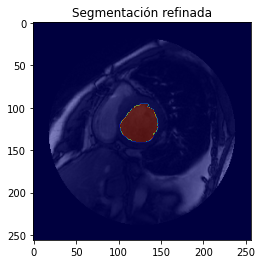

In [7]:
# Refinar la segmentación usando el método 'sitk.BinaryFillhole' para rellenar los huecos que puedan haber quedado.

refinedSeg = sitk.BinaryFillhole(seg)

# Visualizamos la imagen y el gt
plt.figure()
plt.grid(False)
plt.imshow(sitk.GetArrayFromImage(img), cmap="gray")
plt.imshow(sitk.GetArrayFromImage(refinedSeg), cmap="jet", alpha=0.5)
plt.title("Segmentación refinada")

# Cómputo del Dice y Haussdorf comparando ambas segmentaciones

Ahora procederemos a usar el método `medpy.metrics.dc(pred, gt)` (Dice) y `medpy.metrics.hc(pred, gt)` (Haussdorf) para evaluar la calidad de nuestras segmentaciones semi-automáticas u.

Recordar que a los métodos "dc" y "hc" es necesario pasarle como parámetro matrices numpy. Éstas pueden ser extraídas a partir de una imagen SimpleITK usando el método: sitk.GetArrayFromImage(img).




In [8]:
import medpy.metric.binary as metrics

gtNumpy = sitk.GetArrayFromImage(gt)
seg_umbNumpy = sitk.GetArrayFromImage(seg_umb)
segNumpy = sitk.GetArrayFromImage(seg)
refinedSegNumpy = sitk.GetArrayFromImage(refinedSeg)


print("Dice para umbralado:\t\t\t\t" + str(metrics.dc(seg_umbNumpy, gtNumpy)))
print("Dice para crecimiento de regiones:\t\t" + str(metrics.dc(segNumpy, gtNumpy)))
print(
    "Dice para crecimiento de regiones refinado:\t"
    + str(metrics.dc(refinedSegNumpy, gtNumpy))
)

print()

print(
    "Hausdorff (en pixeles) para umbralado:\t\t\t\t"
    + str(metrics.dc(seg_umbNumpy, gtNumpy))
)
print(
    "Hausdorff (en pixeles) para crecimiento de regiones:\t\t"
    + str(metrics.hd(segNumpy, gtNumpy))
)
print(
    "Haussdorf (en pixeles) para crecimiento de regiones refinado:\t"
    + str(metrics.hd(refinedSegNumpy, gtNumpy))
)

Dice para umbralado:				0.3617902471609886
Dice para crecimiento de regiones:		0.9286186384666226
Dice para crecimiento de regiones refinado:	0.9422512234910277

Hausdorff (en pixeles) para umbralado:				0.3617902471609886
Hausdorff (en pixeles) para crecimiento de regiones:		17.0
Haussdorf (en pixeles) para crecimiento de regiones refinado:	4.47213595499958


# UNet para segmentación de imágenes en PyTorch

En la sección anterior, segmentamos una imagen usando el clásico método de crecimiento de regiones implementado en SimpleITK.

Ahora vamos a entrenar una red convolucional con arquitectura U-Net para hacer lo mismo.

## Definición de Dataset propio

Para entrenar el modelo, ya que estamos utilizando un dataset propio, es conveniente cargarlo como Dataset de PyTorch. Esto nos permitirá llamar a funciones como DataLoader que se encargan de la generación de batches de forma automática.

Para más información sobre Datasets y Dataloaders, ver https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [9]:
import os
import pathlib
import re

import numpy as np
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

## Ordena strings en orden natural, sirve para ordenar paths


def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r"(\d+)", string_)]


## La clase Dataset requiere definir 2 funciones:
## __len__ debe devolver la cantidad de elementos presentes en el dataset

## __getitem__ recibe un indice y debe devolver el elemento asociados a ese indice
## Para ello tenemos los paths a las imágenes guardadas en una lista ordenada alfabeticamente

## También puede recibir una lista de transformaciones, las cuales se definirán posteriormente.
## Éstas se aplican al leer cada dato, aquí se pueden utilizar transformaciones aleatorias para aumentación online
## Las transformaciones se cargan al instanciar el dataset.


class OurDataset(Dataset):
    def __init__(self, PATH, transform=None):

        self.img_path = os.path.join(PATH, "Images")
        self.label_path = os.path.join(PATH, "Labels")
        self.transform = transform

        data_root = pathlib.Path(self.img_path)
        all_files = list(data_root.glob("*.png"))
        all_files = [str(path) for path in all_files]
        all_files.sort(key=natural_key)

        self.images = all_files

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.images[idx]
        image = io.imread(img_name, as_gray=True).astype("float")
        image = np.expand_dims(image, axis=2)

        label = img_name.replace(self.img_path, self.label_path)
        label = io.imread(label, as_gray=True)
        label = label.astype(np.bool).astype(np.float)

        sample = {"image": image, "label": label}

        if self.transform:
            sample = self.transform(sample)

        return sample


## Transformaciones a utilizar
## En este caso requeriremos dos:

## Rescale: sirve para que todos los datos tengan el mismo tamaño,
## reescalandolos a un ancho y alto establecido

## ToTensor: esta transformación es esencial, ya que convierte los arreglos de numpy a tensores de PyTorch


class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample["image"], sample["label"]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        lab = transform.resize(label, (new_h, new_w))

        return {"image": img, "label": lab}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample["image"], sample["label"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

        image = image.transpose((2, 0, 1))

        return {
            "image": torch.from_numpy(image).float(),
            "label": torch.from_numpy(label).long(),
        }

# Definición del modelo

Ahora procedemos a definir el modelo U-Net a utilizar. 

* Para facilitar la implementación, se recomienda utilizar convoluciones que no modifiquen el tamaño de la entrada (por ejemplo, convoluciones 2D con kernel de tamaño 3x3, padding = 1 y stride = 1).

* La UNet deberá tener 3 niveles de Max Pooling (de 2 x 2) en el encoder, hasta llegar al cuello de botella en el cuarto nivel. A partir de allí, el decoder deberá contar con 3 niveles de UpSampling, que podrán implementarlo usando la técnica de interpolado bilineal (`torch.nn.Upsample` con los parámetros `(scale_factor=2, mode='bilinear', align_corners=True)`) seguida de **dos** convoluciones.

* Para implementar las Skip Connections, deberán utilizar el método `torch.cat` para concatenar los feature maps del encoder con los del decoder en cada nivel.

* Se recomienda utilizar ReLU como función de no linealidad.

* En cuanto a la cantidad de feature maps, se puede utilizar:
  * Nivel 1: 32 Feature maps
  * Nivel 2: 64 Feature maps
  * Nivel 3: 128 Feature maps
  * Nivel 4: 256 Feature maps

* En la última capa, se recomienda finalizar con una convolución con un kernel de 1x1 que transforme los últimos 32 feature maps en un sólo feature map, y posteriormente utilizar la función no lineal `sigmoid`, generando como salida un único feature map que contendrá la probabilidad de que el pixel sea de clase `foreground`. 


In [10]:
import torch
import torch.nn as nn


def double_conv(in_channels, out_channels, batch_norm: bool = False):
    # Bloque de doble convolución con relu. Se sugiere implementarlo como una sequencia tal como vimos en la
    # teoría de PyTorch. En este bloque luego deberán incorporar BatchNorm para completar la segunda parte de la consigna
    # entregable.

    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=True,
        ),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        nn.ReLU(inplace=True),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=True,
        ),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):
    def __init__(self, n_channels, batch_norm: bool):
        super().__init__()

        # Número base de feature maps que luego irán duplicando.
        base = 32

        self.dconv_down1 = double_conv(n_channels, 32, batch_norm)
        self.dconv_down2 = double_conv(32, 64, batch_norm)
        self.dconv_down3 = double_conv(64, 128, batch_norm)
        self.dconv_down4 = double_conv(128, 256, batch_norm)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        self.dconv_up3 = double_conv(384, 128, batch_norm)
        self.dconv_up2 = double_conv(192, 64, batch_norm)
        self.dconv_up1 = double_conv(96, 32, batch_norm)

        self.conv_last = nn.Conv2d(32, 1, kernel_size=(1, 1))

        # Sigmoide para usar al final
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        # Recuerden que deberán ir quedándose con la salida antes del doble bloque
        # de convolución en el decoder antes de cada maxpooling, para luego ir concatenandola
        # en el decoder con la salida del upsampling de la capa anterior

        # x: batch_size x `n_channels` x 256 x 256
        conv1 = self.dconv_down1(x)  # batch_size x 32 x 256 x 256
        x = self.maxpool(conv1)  # batch_size x 32 x 128 x 128

        conv2 = self.dconv_down2(x)  # batch_size x 64 x 128 x 128
        x = self.maxpool(conv2)  # batch_size x 64 x 64 x 64

        conv3 = self.dconv_down3(x)  # batch_size x 128 x 64 x 64
        x = self.maxpool(conv3)  # batch_size x 128 x 32 x 32

        x = self.dconv_down4(x)  # batch_size x 256 x 32 x 32

        # Upsampling
        x = self.upsample(x)  # batch_size x 256 x 64 x 64

        # Ejemplo para concatenar
        x = torch.cat([x, conv3], dim=1)  # batch_size x 384 x 64 x 64

        x = self.dconv_up3(x)  # batch_size x 128 x 64 x 64
        x = self.upsample(x)  # batch_size x 128 x 128 x 128
        x = torch.cat([x, conv2], dim=1)  # batch_size x 192 x 128 x 128

        x = self.dconv_up2(x)  # batch_size x 64 x 128 x 128
        x = self.upsample(x)  # batch_size x 64 x 256 x 256
        x = torch.cat([x, conv1], dim=1)  # batch_size x 96 x 256 x 256

        x = self.dconv_up1(x) # batch_size x 32 x 256 x 256

        out = self.conv_last(x) # batch_size x 1 x 256 x 256

        out = self.sigmoid(out)

        return out

# Seteando el entorno para GPU

Primero, testeamos si está funcionando la GPU de Colab. Para configurarlo vamos a "Entorno de ejecución --> Cambiar tipo de entorno de ejecución" y en "Acelerador de Hardware" elegimos "GPU".

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("Is GPU available?", torch.cuda.is_available())
print("Model of the GPU:", torch.cuda.get_device_name(0))

Is GPU available? True
Model of the GPU: Tesla P100-PCIE-12GB


# Entrenar el modelo

A continuación definimos un trainer, que hará el loop de entrenamiento y validación, para entrenar el modelo. A diferencia del práctico anterior, donde directamente definíamos el código de entrenamiento en la celda, acá definiremos una función 'trainer' que luego será llamada desde otra celda, para ordenar de mejor forma el código.

Utilizaremos como función de pérdida la Soft Dice que vimos en teoría, con una pequeña variación para evitar inestabilidades. 


In [12]:
import medpy.metric.binary as metrics
import torch.nn.functional as F


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.0 * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice


def trainer(train_dataset, val_dataset, model, args, *, validate: bool = True):
    ## Recibe dos dataset de PyTorch, el modelo y un diccionario de argumentos

    torch.manual_seed(42)

    # Observa si hay GPU disponible, o manda a CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Current device is", device)
    model = model.to(device)
    dice_loss = DiceLoss().to(device)

    # Carga los argumentos para el dataloader
    train_kwargs = {"batch_size": args["batch_size"]}
    val_kwargs = {"batch_size": args["val_batch_size"]}

    # El dataloader recibe argumentos sobre el uso de la GPU, por defecto los siguientes
    cuda_kwargs = {"num_workers": 0, "pin_memory": False, "shuffle": True}

    train_kwargs.update(cuda_kwargs)
    val_kwargs.update(cuda_kwargs)

    # Instancio los DataLoaders, que se encargarán de generar batches de datos de manera online

    train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
    val_loader = torch.utils.data.DataLoader(val_dataset, **val_kwargs)

    # Defino el optimizador, con lr y weight decay preestablecido en el diccionario de argumentos

    optimizer = torch.optim.Adam(
        params=filter(lambda p: p.requires_grad, model.parameters()),
        lr=args["lr"],
        weight_decay=args["weight_decay"],
    )

    # Genero listas para guardar el valor de las funciones de costo promedio por épocas
    train_loss_avg = []
    val_dice_avg = []

    # Mejor valor de Dice, para obtener el mejor modelo en validación
    best = 0

    print("Training ...")

    for epoch in range(args["epochs"]):
        model.train()

        train_loss_avg.append(0)
        num_batches = 0

        for sample_batched in train_loader:
            image, label = sample_batched["image"].to(device), sample_batched[
                "label"
            ].to(device)

            outseg = model(image)

            # backpropagation
            optimizer.zero_grad()

            loss = dice_loss(outseg, label)

            train_loss_avg[-1] += loss.item()

            loss.backward()

            # one step of the optimizer (using the gradients from backpropagation)
            optimizer.step()
            num_batches += 1
            torch.cuda.empty_cache()

        train_loss_avg[-1] /= num_batches

        print(
            "Epoch [%d / %d] train average loss (1 - Dice): %f"
            % (epoch + 1, args["epochs"], train_loss_avg[-1])
        )

        ## Comienzo la etapa de validación

        num_batches = 0

        model.eval()
        val_dice_avg.append(0)

        if validate:
            # Sin calcular gradientes y con el modelo en modo eval()
            with torch.no_grad():
                for sample_batched in val_loader:
                    image, label = sample_batched["image"].to(device), sample_batched[
                        "label"
                    ].to(device)

                    # Modelo de 1 sola clase de salida
                    seg = model(image)[
                        0, 0, :, :
                    ]  # Tomo la primer imagen del batch, y el único canal ya que tiene solo una clase como salida
                    binary = (
                        seg > 0.5
                    )  # Binarizo la segmentacion (que se encuentra en el rango 0-1 por la sigmoidea)

                    val_dice_avg[-1] += metrics.dc(
                        binary.cpu().numpy(), label.cpu().numpy()
                    )  # Calculo Dice sobre la Clase 1
                    num_batches += 1

                    loss_rec = 0
                    torch.cuda.empty_cache()

            val_dice_avg[-1] /= num_batches

            print(
                "Epoch [%d / %d] validation average dice coefficient: %f"
                % (epoch + 1, args["epochs"], val_dice_avg[-1])
            )

            if val_dice_avg[-1] > best:
                best = val_dice_avg[-1]
                print("Model Saved")
                torch.save(model.state_dict(), "best.pt")

        torch.save(model.state_dict(), "aux.pt")
    # Diccionario a devolver
    history = {"Train_Loss": train_loss_avg, "Val_Dice": val_dice_avg}

    return history

Una vez definido el trainer, procedemos a instanciar los datasets, el modelo y comenzar el entrenamiento

In [13]:
## En caso de tener más de una transformacion, se componen con Compose
## Aquí se pueden aplicar transformaciones diferentes para train y validación, permitiendo realizar aumentación de datos en train, por ejemplo.

train_dataset = OurDataset(
    PATH=TRAIN_DATA_DIR, transform=transforms.Compose([ToTensor()])
)

val_dataset = OurDataset(PATH=VAL_DATA_DIR, transform=transforms.Compose([ToTensor()]))

print("Cantidad de imágenes de Entrenamiento", train_dataset.__len__())
print("Cantidad de imágenes de Validacion", val_dataset.__len__())

model = UNet(n_channels=1, batch_norm=False).float()


model_bn = UNet(n_channels=1, batch_norm=True).float()

print("")
print("Arquitectura UNet utilizada sin batch_norm:")
print(model)

print("")
print("Arquitectura UNet utilizada con batch_norm:")
print(model_bn)

Cantidad de imágenes de Entrenamiento 470
Cantidad de imágenes de Validacion 279

Arquitectura UNet utilizada sin batch_norm:
UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Identity()
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Identity()
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Identity()
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Identity()
    (5): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Identity()
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Identity()
    (5): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(


In [14]:
## Acá definimos los hiperparámetros de entrenamiento

args = {}
args["batch_size"] = 28
args["val_batch_size"] = 1
args["epochs"] = 25
args["lr"] = 1e-4
args["weight_decay"] = 1e-5

## Comenzamos a entrenar sin bn
history = trainer(train_dataset, val_dataset, model, args)

Current device is cuda:0
Training ...
Epoch [1 / 25] train average loss (1 - Dice): 0.969593
Epoch [1 / 25] validation average dice coefficient: 0.036992
Model Saved
Epoch [2 / 25] train average loss (1 - Dice): 0.969464
Epoch [2 / 25] validation average dice coefficient: 0.036992
Epoch [3 / 25] train average loss (1 - Dice): 0.969021
Epoch [3 / 25] validation average dice coefficient: 0.036992
Model Saved
Epoch [4 / 25] train average loss (1 - Dice): 0.967323
Epoch [4 / 25] validation average dice coefficient: 0.101493
Model Saved
Epoch [5 / 25] train average loss (1 - Dice): 0.928490
Epoch [5 / 25] validation average dice coefficient: 0.146243
Model Saved
Epoch [6 / 25] train average loss (1 - Dice): 0.822331
Epoch [6 / 25] validation average dice coefficient: 0.255327
Model Saved
Epoch [7 / 25] train average loss (1 - Dice): 0.748149
Epoch [7 / 25] validation average dice coefficient: 0.223258
Epoch [8 / 25] train average loss (1 - Dice): 0.676751
Epoch [8 / 25] validation average d

In [15]:
## Comenzamos a entrenar con bn
history_bn = trainer(train_dataset, val_dataset, model_bn, args)

Current device is cuda:0
Training ...
Epoch [1 / 25] train average loss (1 - Dice): 0.947367
Epoch [1 / 25] validation average dice coefficient: 0.000000
Epoch [2 / 25] train average loss (1 - Dice): 0.928526
Epoch [2 / 25] validation average dice coefficient: 0.004586
Model Saved
Epoch [3 / 25] train average loss (1 - Dice): 0.919633
Epoch [3 / 25] validation average dice coefficient: 0.256997
Model Saved
Epoch [4 / 25] train average loss (1 - Dice): 0.914710
Epoch [4 / 25] validation average dice coefficient: 0.563424
Model Saved
Epoch [5 / 25] train average loss (1 - Dice): 0.912143
Epoch [5 / 25] validation average dice coefficient: 0.600178
Model Saved
Epoch [6 / 25] train average loss (1 - Dice): 0.910342
Epoch [6 / 25] validation average dice coefficient: 0.613750
Model Saved
Epoch [7 / 25] train average loss (1 - Dice): 0.908274
Epoch [7 / 25] validation average dice coefficient: 0.702387
Model Saved
Epoch [8 / 25] train average loss (1 - Dice): 0.906236
Epoch [8 / 25] validati

Procedemos a plotear los valores de la funcion de costo en Train y del Coeficiente Dice en Validacion.

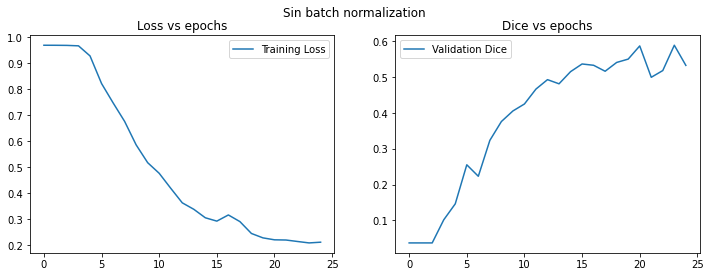

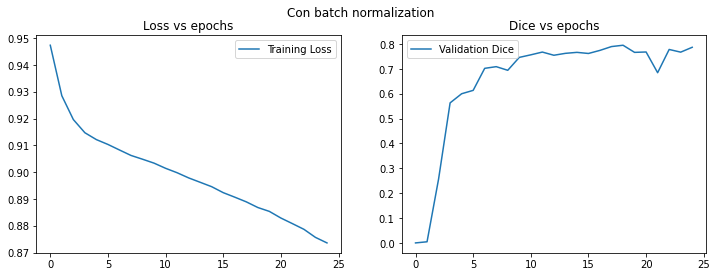

In [16]:
def plot_history(history, ax):
    ax[0].set_title("Loss vs epochs")
    ax[0].plot(history["Train_Loss"])
    ax[0].legend(["Training Loss"])

    ax[1].set_title("Dice vs epochs")
    ax[1].plot(history["Val_Dice"])
    ax[1].legend(["Validation Dice"])


fig_results, ax = plt.subplots(1, 2, figsize=(12, 4))
fig_results.suptitle("Sin batch normalization")
plot_history(history, ax)


fig_results_bn, ax = plt.subplots(1, 2, figsize=(12, 4))
fig_results_bn.suptitle("Con batch normalization")
plot_history(history_bn, ax)

# Testeando el modelo y generando imágenes de salida

Una vez entrenado el modelo, procedemos a generar las predicciones sobre las imágenes de test.



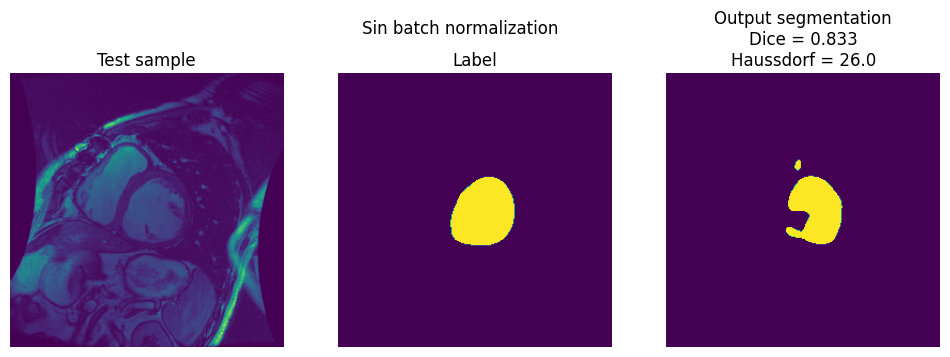

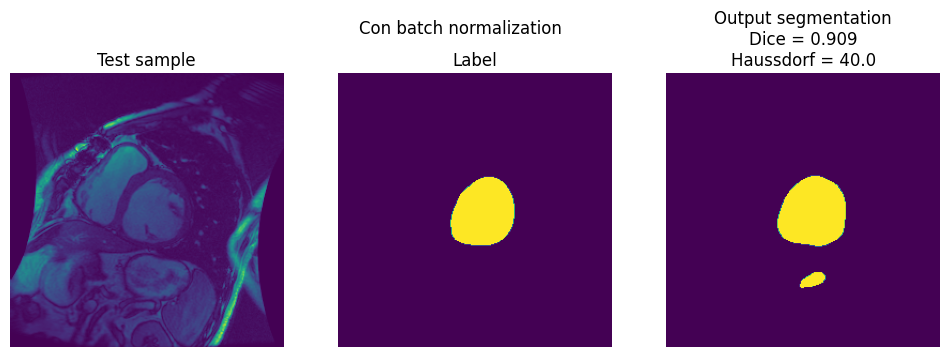

In [17]:
## Cargo los pesos entrenados
def plot_eval_sample(model, dataset, ax, idx=1):

    sample = dataset[idx]
    image, label = sample["image"], sample["label"]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    ## Le agrego el batchsize = 1 a la imagen
    data = image.unsqueeze(axis=0).to(device)

    # print("Shape:", data.shape, "BatchSize x Channels x Height x Width")

    ## Segmento la imagen

    with torch.no_grad():
        seg = model(data)[0, 0, :, :]  # quitando el batchsize

    binary = seg > 0.5
    if binary.sum() == 0:
        # evito errores y reporto metricas similares a las reales.
        dice = 0
        haussdorf = (torch.tensor(binary.shape) ** 2).sum().sqrt()
    else:
        dice = metrics.dc(binary.cpu().numpy(), label.cpu().numpy())
        haussdorf = metrics.hd(binary.cpu().numpy(), label.cpu().numpy())

    ax[0].axis("off")
    ax[0].imshow(image[0, :, :])
    ax[0].set_title("Test sample")

    ax[1].axis("off")
    ax[1].imshow(label)
    ax[1].set_title("Label")

    ax[2].axis("off")
    ax[2].imshow(binary.cpu().numpy())
    ax[2].set_title(
        f"Output segmentation\nDice = {dice:.3f}\nHaussdorf = {haussdorf:.1f}"
    )


idx = 6

fig, ax = plt.subplots(1, 3, dpi=100, figsize=(12, 4))
fig.suptitle("Sin batch normalization")
plot_eval_sample(model, val_dataset, ax, idx=idx)

fig, ax = plt.subplots(1, 3, dpi=100, figsize=(12, 4))
fig.suptitle("Con batch normalization")
plot_eval_sample(model_bn, val_dataset, ax, idx=idx)

# Visualizando resultados de test

Crear un dataloader para el dataset de test y evaluar el coeficiente Dice y la distancia de Haussdorf de todas las imágenes de test. Reportar el resultado en un boxplot.

In [18]:
import seaborn as sns

Sin BN               BN          
        Dice Haussdorf   Dice Haussdorf
Train  0.658    48.253  0.843    10.681
Val    0.533    82.313  0.787    45.414
Test   0.411   120.542  0.749    43.033

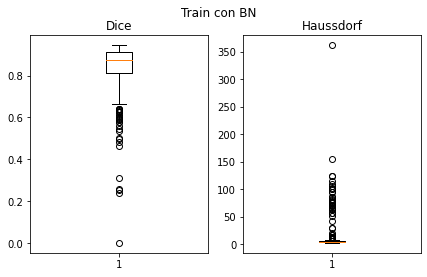

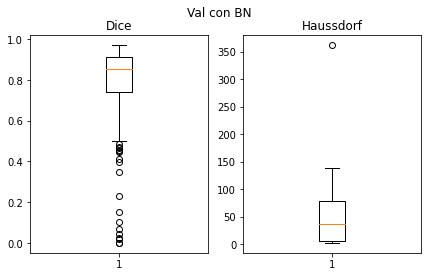

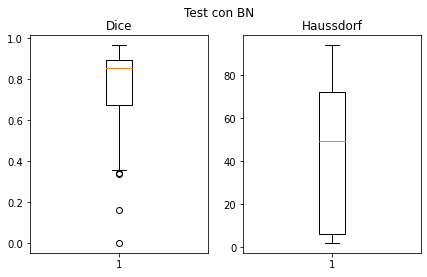

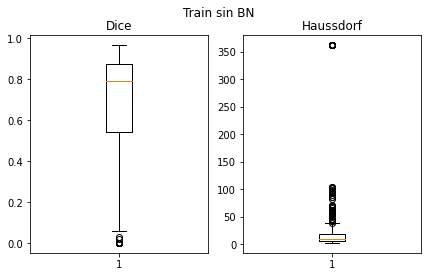

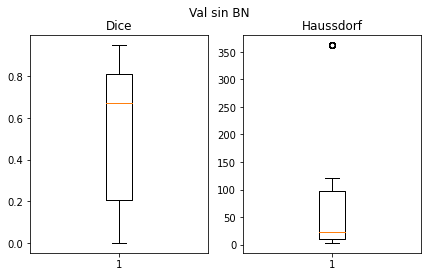

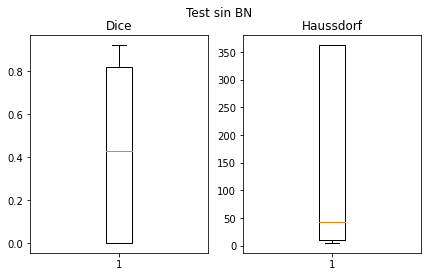

In [19]:
test_dataset = OurDataset(
    PATH=TEST_DATA_DIR, transform=transforms.Compose([Rescale(256), ToTensor()])
)

# Sin calcular gradientes y con el modelo en modo eval()


def eval_loader(model, loader, ax):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loader_dice = []
    loader_haussdorf = []

    model.eval()
    with torch.no_grad():
        for sample_batched in loader:
            images, labels = sample_batched["image"].to(device), sample_batched[
                "label"
            ].to(device)
            # Modelo de 1 sola clase de salida
            # Tomo la primer imagen del batch, y el único canal ya que tiene solo una clase como salida
            segs = model(images)

            for seg, label in zip(segs, labels):
                seg = seg[0]  # me quedo con el unico canal

                # Binarizo la segmentacion (que se encuentra en el rango 0-1 por la sigmoidea)
                binary = seg > 0.5
                if binary.sum() == 0:
                    # evito errores y reporto metricas similares a las reales.
                    dice = 0
                    haussdorf = (torch.tensor(binary.shape) ** 2).sum().sqrt()
                else:
                    dice = metrics.dc(binary.cpu().numpy(), label.cpu().numpy())
                    haussdorf = metrics.hd(binary.cpu().numpy(), label.cpu().numpy())

                loader_dice.append(dice)
                loader_haussdorf.append(haussdorf)
    ax[0].boxplot(np.array(loader_dice))
    ax[0].set_title("Dice")
    ax[1].boxplot(np.array(loader_haussdorf))
    ax[1].set_title("Haussdorf")
    return np.array(loader_dice).mean(), np.array(loader_haussdorf).mean()


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=48)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=48)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=48)

import pandas as pd

columns = pd.MultiIndex.from_product([["Sin BN", "BN"], ["Dice", "Haussdorf"]])
index = ["Train", "Val", "Test"]
df = pd.DataFrame(columns=columns, index=index)

fig_train_bn, ax = plt.subplots(1, 2, figsize=(7, 4))
fig_train_bn.patch.set_color("white")
fig_train_bn.suptitle("Train con BN")
df.loc["Train", "BN"] = eval_loader(model_bn, train_loader, ax)

fig_val_bn, ax = plt.subplots(1, 2, figsize=(7, 4))
fig_val_bn.patch.set_color("white")
fig_val_bn.suptitle("Val con BN")
df.loc["Val", "BN"] = eval_loader(model_bn, val_loader, ax)

fig_test_bn, ax = plt.subplots(1, 2, figsize=(7, 4))
fig_test_bn.patch.set_color("white")
fig_test_bn.suptitle("Test con BN")
df.loc["Test", "BN"] = eval_loader(model_bn, test_loader, ax)

fig_train, ax = plt.subplots(1, 2, figsize=(7, 4))
fig_train.patch.set_color("white")
fig_train.suptitle("Train sin BN")
df.loc["Train", "Sin BN"] = eval_loader(model, train_loader, ax)

fig_val, ax = plt.subplots(1, 2, figsize=(7, 4))
fig_val.patch.set_color("white")
fig_val.suptitle("Val sin BN")
df.loc["Val", "Sin BN"] = eval_loader(model, val_loader, ax)


fig_test, ax = plt.subplots(1, 2, figsize=(7, 4))
fig_test.patch.set_color("white")
fig_test.suptitle("Test sin BN")
df.loc["Test", "Sin BN"] = eval_loader(model, test_loader, ax)

df = df.applymap(lambda x: round(x, 3))
df

# Entregable:

1. Deberán implementar la arquitectura UNet y reportar los resultados en los datos de test, reportando el coeficiente Dice y el coeficiente Haussdorf mediante un boxplot.

2. Luego deberán incorporarle Batch Normalization (utilizando la clase `torch.nn.BatchNorm2d`) en las capas convolucionales de dicha arquitectura (en todas excepeto en la última) y comparar el rendimiento con el modelo sin Batch Normalization. Recordar que BatchNorm se coloca a la salida de la capa, antes de pasar por la función de activación.

1. Se implementó la UNet con la arquitectura sugerida. Se presenta en modo tabla los resultados para train, validación y test de los coeficientes de Dice y Haussdorf.

In [20]:
df["Sin BN"]

,Dice,Haussdorf
Train,0.658,48.253
Val,0.533,82.313
Test,0.411,120.542


Ademas se muetran los boxplots para cada uno de los conjuntos:

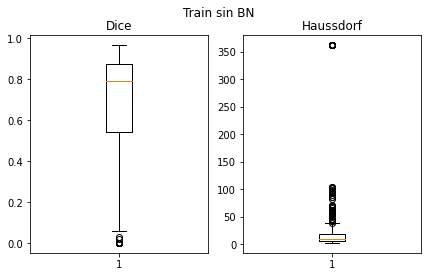

In [21]:
fig_train

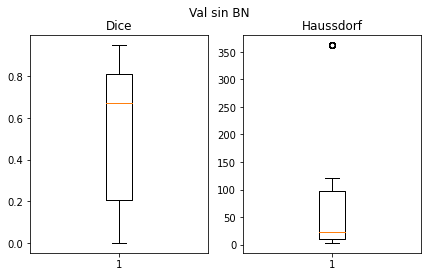

In [22]:
fig_val

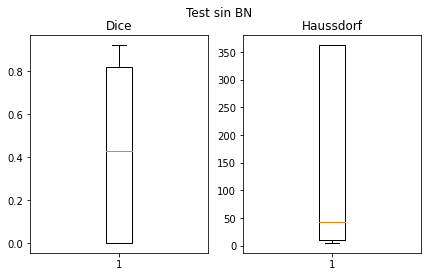

In [23]:
fig_test

Se observa que el rendimiento disminuye en los conjuntos de Test y Val respecto a Train, esto es esperable. Además, en los boxplots se ve como existe una gran variabilidad del Dice, no es algo estable.


Notar que los valores de Dice y Haussdord son bastante inferiores a los obtenidos mediante el método ConnectedThreshold + BinaryFillhole; sin embargo, cabe decir que la UNet no requiere ningún tipo de interacción de una persona que marque manualmente puntos iniciales, es decir, es completamente automático.


2. Se incorporó batch normalization a la arquitectura, esto mejoro los resultados sobre todo los conjuntos de datos. A continuación se muestra la tabla de resultados y boxplots.

In [24]:
df["BN"]

,Dice,Haussdorf
Train,0.843,10.681
Val,0.787,45.414
Test,0.749,43.033


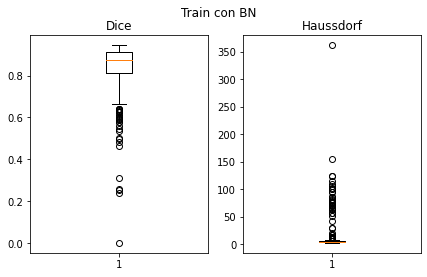

In [25]:
fig_train_bn

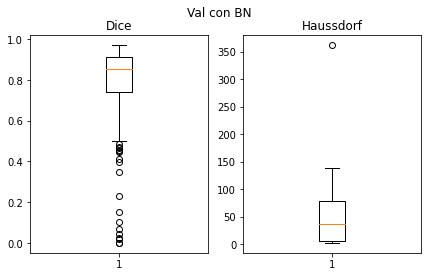

In [26]:
fig_val_bn

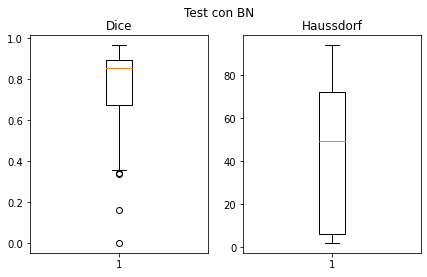

In [27]:
fig_test_bn

Nuevamente, agregando batch normalization se aprecia que los resultados se degradan en los conjuntos de Val y Test.

Sin embargo, los boxplots muestran resultados más concentrados entre valores altos de Dice y valores bajos de Haussdorf, es decir, hay menos variabilidad.

Para que la comparación sea más clara, se muestra en una tabla todos los resultados juntos:

In [28]:
df

Sin BN               BN          
        Dice Haussdorf   Dice Haussdorf
Train  0.658    48.253  0.843    10.681
Val    0.533    82.313  0.787    45.414
Test   0.411   120.542  0.749    43.033

Comparativamente se observa que el Dice mejora considerablemente, en test aumenta $0.3$ aproximadamente. También se logra que el Haussdorf disminuya a más de la mitad.

Con el fin de analizar el comportamiento anterior, en las siguientes celdas se muestran ejemplos del conjunto de test con y sin batch normalization.

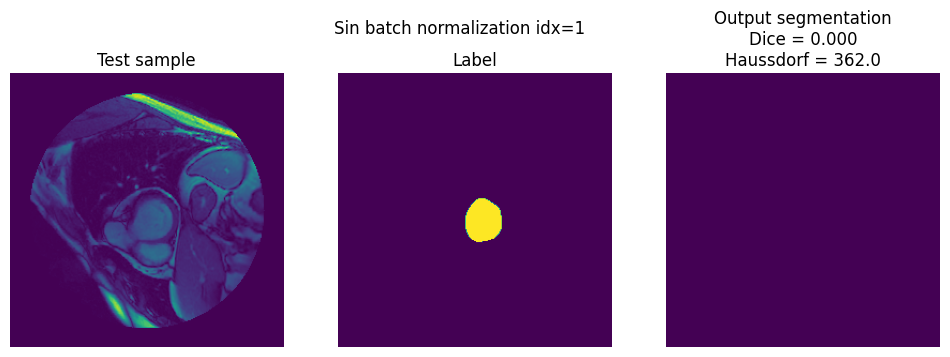

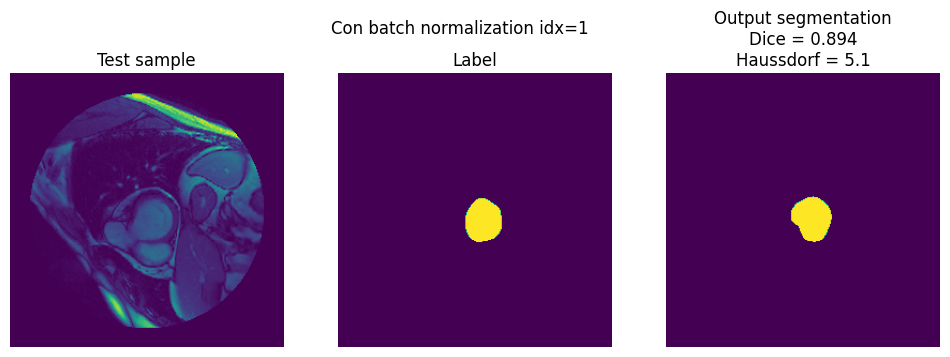

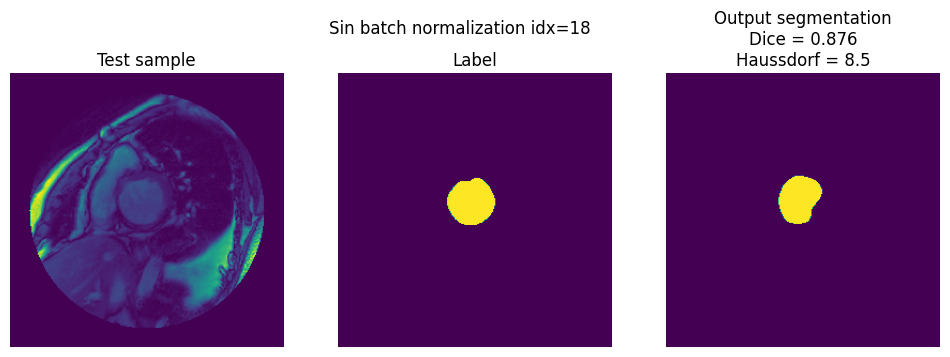

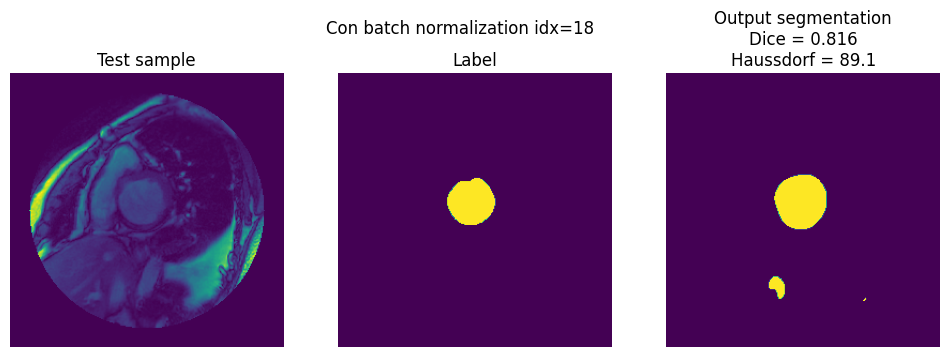

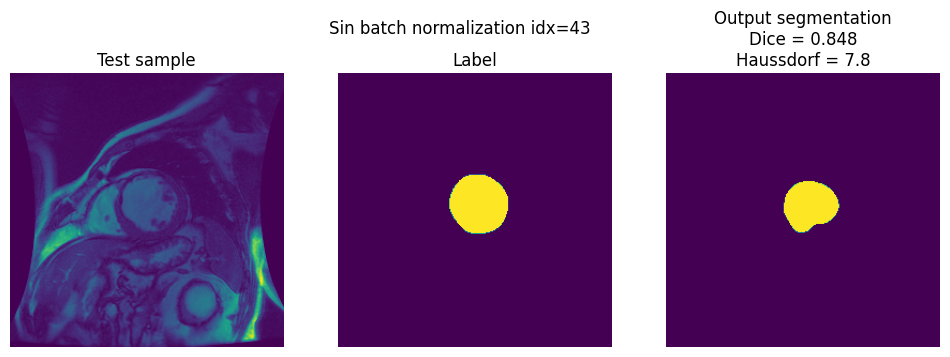

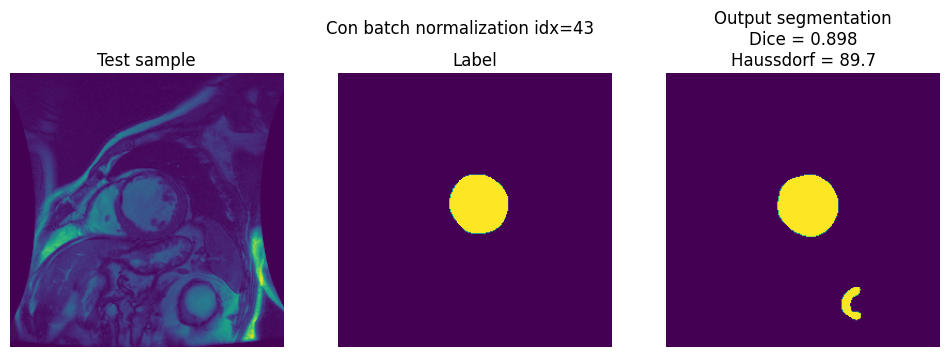

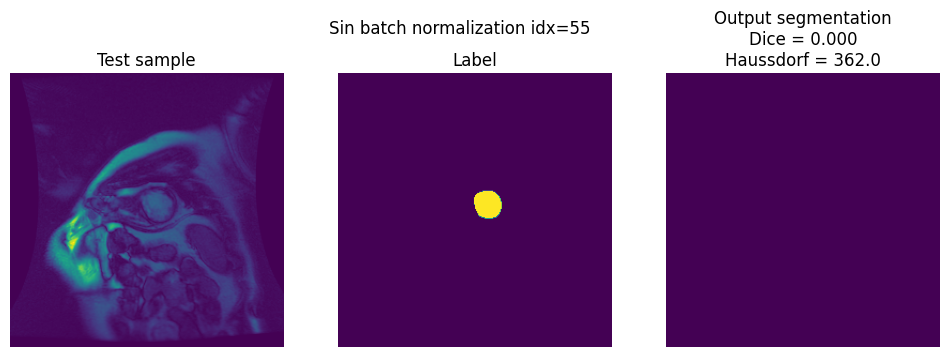

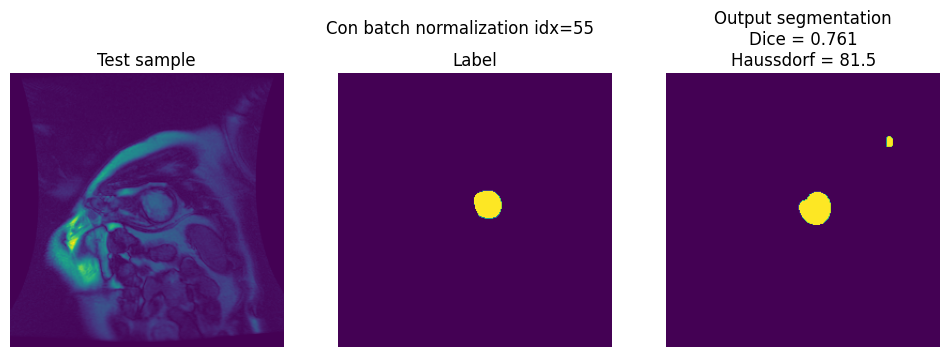

In [29]:
for idx in [1, 18, 43, 55]:
    fig, ax = plt.subplots(1, 3, dpi=100, figsize=(12, 4))
    fig.suptitle(f"Sin batch normalization idx={idx}")
    plot_eval_sample(model, test_dataset, ax, idx=idx)
    fig, ax = plt.subplots(1, 3, dpi=100, figsize=(12, 4))
    fig.suptitle(f"Con batch normalization idx={idx}")
    plot_eval_sample(model_bn, test_dataset, ax, idx=idx)

Se aprecia que con BN, la forma se asemeja más a la real, es más circular con menos agujeros, lo que coincide con Dice mayores. Además, con BN también se logran mejores Haussdorf. La variabilidad de los resultados se reduce también al usar BN.


Observar que se da incluso el caso de que sin BN la segmentación es nula (idx=0 en las figuras anteriores), no encuentra el ventrículo izquierdo, pero con BN si logra una segmentación razonable.


En resumen, el usar BN presenta múltiples beneficios para el modelo.


-----


**Nota**: Existen varias imágenes del conjunto de test cuya segmentación sin BN es nula. El criterio utilizado fue que el Dice sea 0. Mientras que el Haussdorf sea igual a la distancia diagonal de la imagen (que es la mayor distancia entre dos píxeles de la imagen), aunque bien podría ser otro el criterio. En caso de no definir estos criterios, las funciones de medpy generan un error, y calcular los promedios omitiendo estos casos sería un error.